In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from ase.io import read
import torch
from tqdm import tqdm
from glob import glob
from pathlib import Path
from itertools import product
from mace import data, tools
from mace.tools import torch_geometric
from mace.tools.torch_tools import to_numpy
from contextlib import contextmanager


sns.set_theme(style="whitegrid")

In [3]:
test_files = sorted(glob("/home/hatemh/BOTNet-datasets/dataset_3BPA/test_*"))
checkpoint_files = sorted(glob("/home/hatemh/mace/experiments/checkpoints/*.model"))
num_tests = len(test_files)
num_checkpoints = len(checkpoint_files)
total_combinations = num_tests * num_checkpoints
total_combinations

96

In [4]:
z_table = tools.utils.AtomicNumberTable([1, 6, 7, 8])
r_max = 5.0
device = "cuda"

In [5]:
def parse_clip_grad(name: str):
    part = list(filter(lambda x: x.startswith("cg"), name.split("_")))

    if len(part) == 0:
        return -1

    return float(part[0].split("-")[-1])


def parse_loss_scale(name: str):
    part = list(filter(lambda x: x.startswith("ls"), name.split("_")))

    if len(part) == 0:
        return 1.0

    return float(part[0].split("-")[-1])


def parse_values(checkpoint_file: str):
    name = Path(checkpoint_file).stem
    seed = int(name.split("-")[-1])
    dtype = "float32" if name.find("fp64") == -1 else "float64"
    clip_grad = parse_clip_grad(name)
    loss_scale = parse_loss_scale(name)
    return {
        "seed": seed,
        "dtype": dtype,
        "clip_grad": clip_grad,
        "loss_scale": loss_scale,
    }


def make_loader(atoms_list):
    configs = data.utils.config_from_atoms_list(atoms_list)
    dataset = [
        data.AtomicData.from_config(c, z_table=z_table, cutoff=r_max) for c in configs
    ]
    loader = torch_geometric.dataloader.DataLoader(
        dataset=dataset, batch_size=32, shuffle=False, drop_last=False
    )
    return loader


@contextmanager
def default_dtype(dtype: torch.dtype):
    init = torch.get_default_dtype()
    torch.set_default_dtype(dtype)
    yield
    torch.set_default_dtype(init)


def eval_model(checkpoint_file: str, test_file: str, device: str = device):
    model = torch.load(checkpoint_file)
    model.to(device)
    model_dtype = {p.dtype for p in model.parameters()}.pop()

    with default_dtype(model_dtype):
        atoms_list = read(test_file, index=":")
        loader = make_loader(atoms_list)
        errors = []

        for batch in tqdm(loader):
            batch = batch.to(device)
            target = to_numpy(batch.energy)
            output = model(batch.to_dict())
            pred = to_numpy(output["energy"])
            errors.append(np.abs(target - pred))
        
    del model
    del loader
    torch.cuda.empty_cache()
    
    errors = 1e3 * np.concatenate(errors, axis=0)
        
    
    return {
        **parse_values(checkpoint_file),
        "dataset": Path(test_file).stem,
        "mae (meV)": np.mean(errors),
        "rmse (meV)": np.sqrt(np.mean(errors**2)),
    }

In [6]:
records = [
    eval_model(cf, tf)
    for cf, tf in tqdm(product(checkpoint_files, test_files), total=total_combinations)
]
df = pd.DataFrame(records)
df

100%|██████████| 96/96 [49:20<00:00, 30.84s/it]


,seed,dtype,clip_grad,loss_scale,dataset,mae (meV),rmse (meV)
0,1702,float32,10.0,1.0,test_1200K,33.243301,47.228992
1,1702,float32,10.0,1.0,test_300K,2.387283,3.410165
2,1702,float32,10.0,1.0,test_600K,7.803365,11.978807
3,1702,float32,10.0,1.0,test_dih,13.575978,36.941505
4,285,float32,10.0,1.0,test_1200K,44.120171,61.100391
...,...,...,...,...,...,...,...
91,285,float32,-1.0,1.0,test_dih,5.729943,15.112409
92,43,float32,-1.0,1.0,test_1200K,23.968925,34.493740
93,43,float32,-1.0,1.0,test_300K,2.329941,3.306375
94,43,float32,-1.0,1.0,test_600K,6.501586,10.945271


In [7]:
df.to_parquet("eval_mace_sweep.parquet")

In [8]:
sweep_results = df.groupby(["dtype", "clip_grad", "loss_scale", "dataset"])["rmse (meV)"].describe()
sweep_results.sort_values(by=["mean"])

count       mean        std  \
dtype   clip_grad loss_scale dataset                                   
float64 -1.0      1000.0     test_300K     3.0   2.847039   0.204082   
                  1.0        test_300K     3.0   2.863910   0.204485   
float32 -1.0      1.0        test_300K     3.0   3.072941   0.332231   
                  1000.0     test_300K     3.0   3.088956   0.371953   
float64  10.0     1.0        test_300K     3.0   3.419978   0.215689   
float32  10.0     1.0        test_300K     3.0   3.477184   0.348296   
                  1000.0     test_300K     3.0   8.059883   3.202818   
float64 -1.0      1.0        test_600K     3.0  10.506742   0.196648   
                  1000.0     test_600K     3.0  10.530708   0.123310   
float32 -1.0      1.0        test_600K     3.0  10.546842   0.637059   
                  1000.0     test_600K     3.0  10.649469   0.683302   
float64 -1.0      1.0        test_dih      3.0  10.727352   1.642192   
                  1000.0     test_dih      3.0  10.752583   1.504423   
         10.0     1.0        test_600K     3.0  11.729941   0.358211   
float32  10.0     1.0        test_600K     3.0  11.877275   0.518758   
float64  10.0     1000.0     test_300K     3.0  12.555176   6.461553   
float32 -1.0      1.0        test_dih      3.0  14.639396   3.507324   
                  1000.0     test_dih      3.0  15.088966   3.621133   
         10.0     1000.0     test_600K     3.0  15.857318   2.571010   
float64  10.0     1000.0     test_600K     3.0  19.327126   5.354834   
                  1.0        test_dih      3.0  30.358709   1.961211   
float32  10.0     1.0        test_dih      3.0  33.431960   4.633688   
float64 -1.0      1000.0     test_1200K    3.0  33.499629   3.169439   
                  1.0        test_1200K    3.0  33.533492   3.331001   
float32 -1.0      1.0        test_1200K    3.0  34.184944   0.847804   
                  1000.0     test_1200K    3.0  34.206406   1.178744   
float64  10.0     1000.0     test_dih      3.0  42.702840   3.123457   
float32  10.0     1000.0     test_dih      3.0  42.977034   1.298705   
float64  10.0     1.0        test_1200K    3.0  52.138537   8.926682   
float32  10.0     1.0        test_1200K    3.0  56.690203   8.199912   
                  1000.0     test_1200K    3.0  74.171979  14.622674   
float64  10.0     1000.0     test_1200K    3.0  78.105008  19.385073   

                                               min        25%        50%  \
dtype   clip_grad loss_scale dataset                                       
float64 -1.0      1000.0     test_300K    2.621991   2.760510   2.899030   
                  1.0        test_300K    2.632460   2.785816   2.939172   
float32 -1.0      1.0        test_300K    2.692579   2.956225   3.219871   
                  1000.0     test_300K    2.660986   2.966307   3.271628   
float64  10.0     1.0        test_300K    3.276651   3.295949   3.315247   
float32  10.0     1.0        test_300K    3.167267   3.288716   3.410165   
                  1000.0     test_300K    6.208804   6.210736   6.212668   
float64 -1.0      1.0        test_600K   10.333608  10.399841  10.466074   
                  1000.0     test_600K   10.419576  10.464380  10.509185   
float32 -1.0      1.0        test_600K    9.812104  10.347627  10.883150   
                  1000.0     test_600K    9.864787  10.417567  10.970347   
float64 -1.0      1.0        test_dih     9.537551   9.790552  10.043554   
                  1000.0     test_dih     9.847713   9.884260   9.920808   
         10.0     1.0        test_600K   11.521648  11.523129  11.524610   
float32  10.0     1.0        test_600K   11.315256  11.647032  11.978807   
float64  10.0     1000.0     test_300K    5.457328   9.784837  14.112347   
float32 -1.0      1.0        test_dih    10.919571  13.015990  15.112409   
                  1000.0     test_dih    11.030768  13.638275  16.245781   
         10.0     1000.0     test_600K   14.358444  14.372968  14.387492

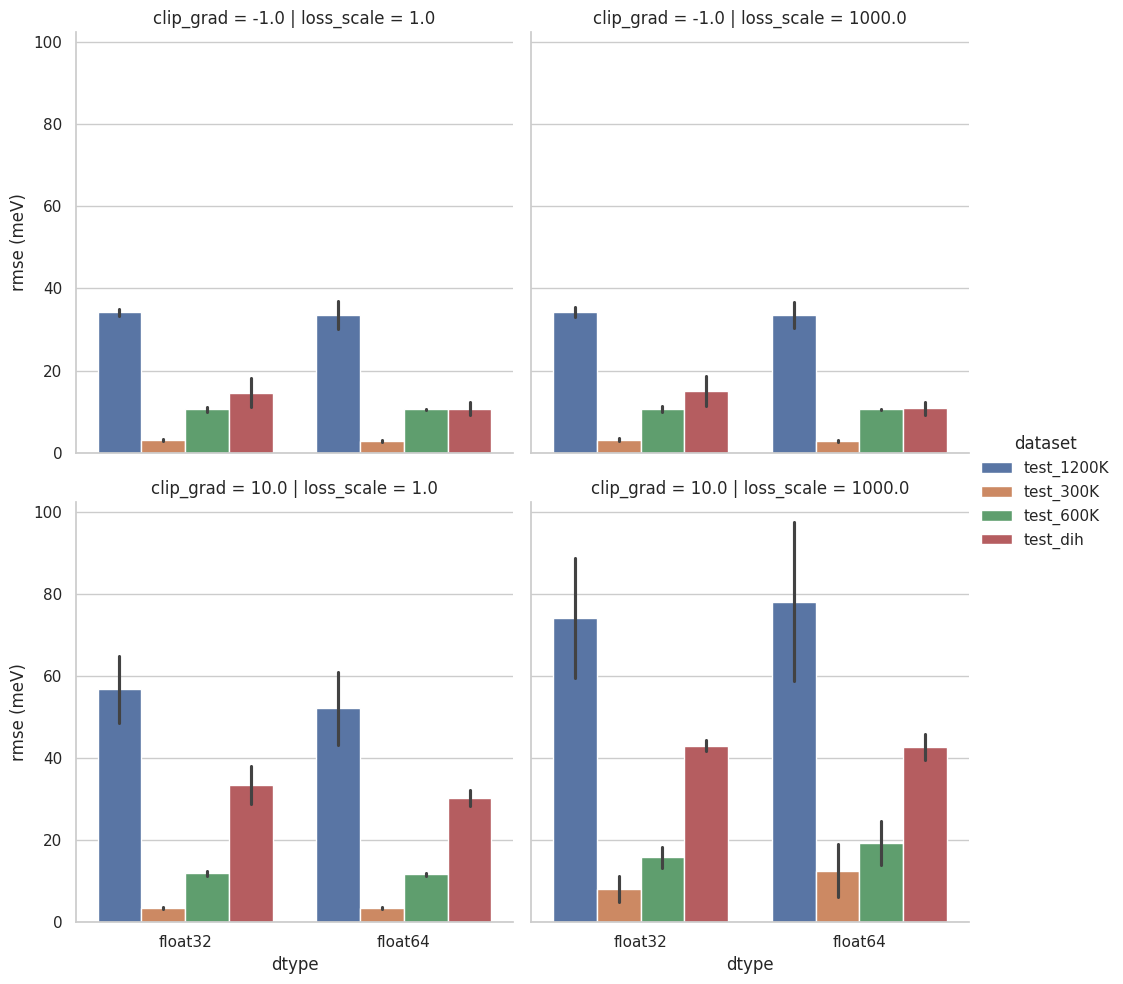

In [9]:
df = pd.read_parquet("eval_mace_sweep.parquet")
sns.catplot(
    data=df,
    x="dtype",
    y="rmse (meV)",
    col="loss_scale",
    row="clip_grad",
    hue="dataset",
    kind="bar",
    errorbar="sd",
)

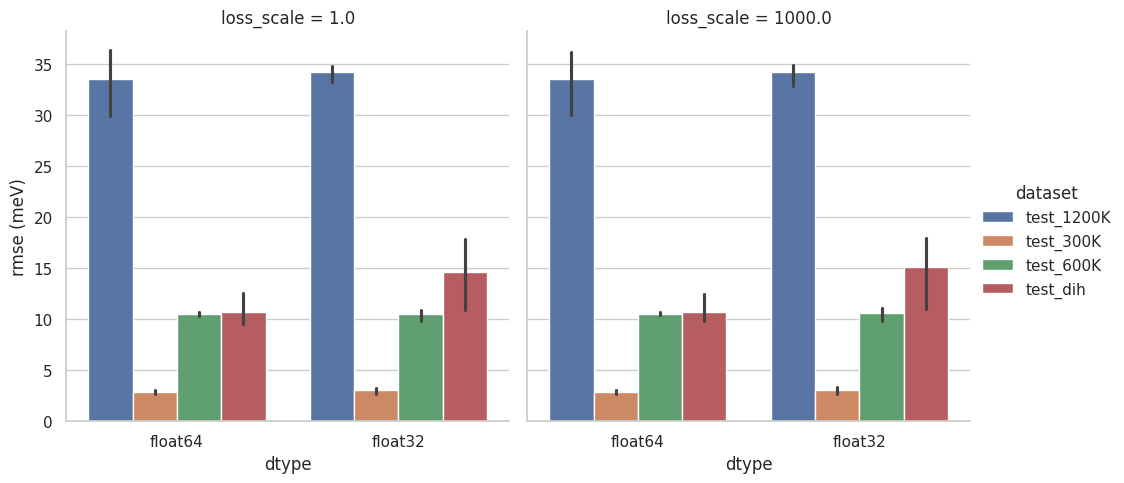

In [10]:
mask = (df["clip_grad"] == -1)
sns.catplot(data=df[mask], x="dtype", y="rmse (meV)", hue="dataset", col="loss_scale", kind="bar")

In [11]:
dataset = read("/home/hatemh/BOTNet-datasets/dataset_3BPA/test_dih.xyz", index=":")

alpha, beta, gamma = np.stack([d.info["dihedrals"] for d in dataset]).T
mask = (alpha == 71) & (beta == 120)
subset = [d for d, tf in zip(dataset, mask) if tf]
len(subset)

50

<Axes: >

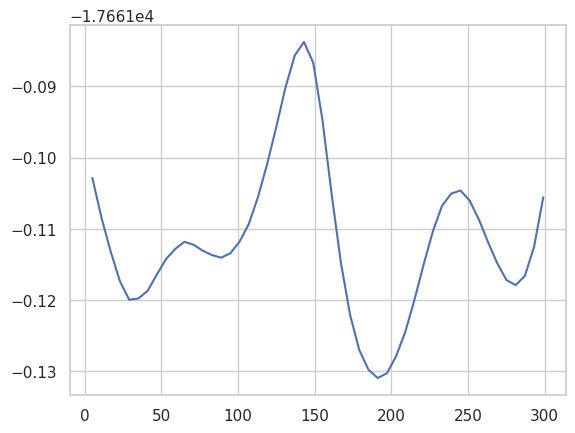

In [12]:
Eref = np.stack([d.info["energy"] for d in subset])
sns.lineplot(x=gamma[mask], y=Eref)

In [13]:
def eval_slice(checkpoint_file: str, device: str = device):
    model = torch.load(checkpoint_file)
    model.to(device)
    model_dtype = {p.dtype for p in model.parameters()}.pop()

    with default_dtype(model_dtype):
        loader = make_loader(subset)
        preds = []
        errors = []

        for batch in tqdm(loader):
            batch = batch.to(device)
            target = to_numpy(batch.energy)
            output = model(batch.to_dict())
            pred = to_numpy(output["energy"])
            preds.append(pred)
            errors.append(np.abs(target - pred))
        
    del model
    del loader
    torch.cuda.empty_cache()
    
    errors = 1e3 * np.concatenate(errors, axis=0)
    results = pd.DataFrame({"alpha": alpha[mask],
        "beta": beta[mask],
        "gamma": gamma[mask],
        "E predicted (eV)": np.concatenate(preds, axis=0)})

    
    for k, v in parse_values(checkpoint_file).items():
        results[k] = v
    
    return results

In [14]:
checkpoints = glob("checkpoints/model_fp64_run*.model") + glob("checkpoints/model_run*.model")
slice_df = pd.concat([eval_slice(c) for c in checkpoints])
slice_df.head()

100%|██████████| 2/2 [00:00<00:00,  4.33it/s]


,alpha,beta,gamma,E predicted (eV),seed,dtype,clip_grad,loss_scale
0,71.0,120.0,5.0,-17661.107438,285,float64,-1,1.0
1,71.0,120.0,11.0,-17661.112472,285,float64,-1,1.0
2,71.0,120.0,17.0,-17661.116663,285,float64,-1,1.0
3,71.0,120.0,23.0,-17661.120774,285,float64,-1,1.0
4,71.0,120.0,29.0,-17661.123327,285,float64,-1,1.0


<Axes: xlabel='gamma', ylabel='E predicted (eV)'>

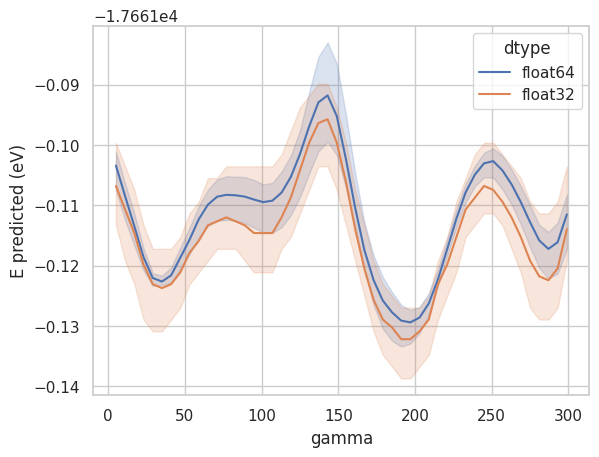

In [15]:
def minmax(x):
  return x.min(), x.max()
  
sns.lineplot(data=slice_df, x="gamma", y="E predicted (eV)", hue="dtype", errorbar=minmax)

In [16]:
checkpoints = glob("checkpoints/model_fp64_ls-1000_run*.model") + glob("checkpoints/model_ls-1000_run*.model")
slice_df = pd.concat([eval_slice(c) for c in checkpoints])
slice_df.head()

100%|██████████| 2/2 [00:00<00:00,  4.28it/s]


,alpha,beta,gamma,E predicted (eV),seed,dtype,clip_grad,loss_scale
0,71.0,120.0,5.0,-17661.108431,285,float64,-1,1000.0
1,71.0,120.0,11.0,-17661.113343,285,float64,-1,1000.0
2,71.0,120.0,17.0,-17661.117342,285,float64,-1,1000.0
3,71.0,120.0,23.0,-17661.121270,285,float64,-1,1000.0
4,71.0,120.0,29.0,-17661.123707,285,float64,-1,1000.0


<Axes: xlabel='gamma', ylabel='E predicted (eV)'>

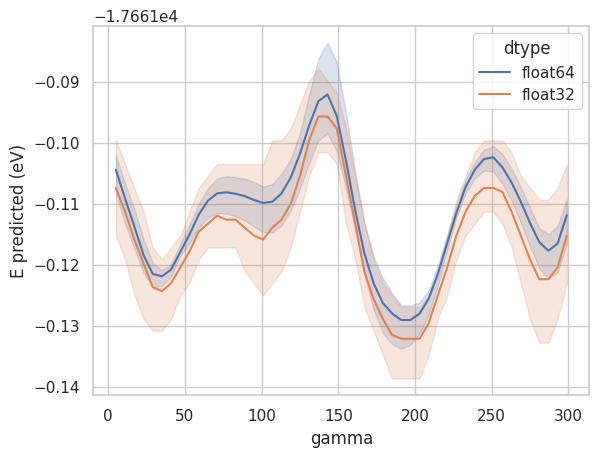

In [17]:
sns.lineplot(data=slice_df, x="gamma", y="E predicted (eV)", hue="dtype", errorbar=minmax)